## Imports

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device name: ", device)

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

device name:  cuda:0


## Load Data (Cifar 10)

In [43]:
model_tag = input("Enter model tag: ")
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
run_name = model_tag + '_' + dt_string
os.mkdir("./runs/" + run_name)

# initialize summary writer for Tensorboard
writer = SummaryWriter('./runs/' + run_name)

data_path = "/data2/users/lr4617/data/"
download_bool = False
batch_size = 64

if len(os.listdir(data_path)) == 0:
    download_bool = True

transform_data = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=download_bool, transform=transform_data)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=download_bool, transform=transform_data)

train_loader = DataLoader(cifar10_train, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size = batch_size, shuffle=False)

# classes label for Cifar 10 dataset (just for display)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Visualize Dataset

### Helper Function

In [44]:
def imshow_(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5    # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        # plt.imshow(np.transpose((npimg* 255).astype(np.uint8), (1, 2, 0)))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

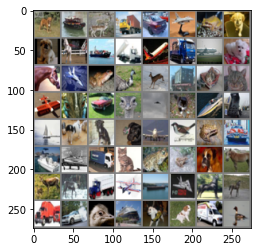

In [45]:
# dislay batch images
data_iter = iter(train_loader)
samples, labels = data_iter.next()

img = tv.utils.make_grid(samples)
imshow_(img)

## Models

In [50]:
class CNN(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.device = device

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x).to(device)

        return x

class CNN_2(nn.Module):
    def __init__(self, device):

        super().__init__()
        self.device = device
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x).to(device)
        return x


class CNN_3(nn.Module):
    def __init__(self, device):

        super().__init__()
        self.device = device
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(1600, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x).to(device)
        return x

net = CNN_3(device)

### Tensorboard Test

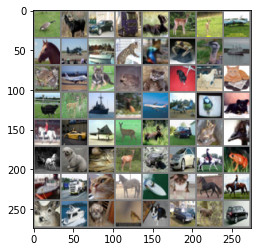

In [51]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = tv.utils.make_grid(images)

# show images
imshow_(img_grid, one_channel=False)

# write to tensorboard
writer.add_image('Batch Example', img_grid)
writer.add_graph(net, images)
writer.close()

## Utils

In [52]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(28*8, 28*8))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
        imshow_(images.cpu()[idx], one_channel=False)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"), fontsize=84)
    return fig

In [53]:
def train (loader, model, n_epochs=30):
    opt = optim.SGD(model.parameters(), lr=1e-1)

    for epoch_num in range(n_epochs):
        total_loss, total_err = 0.,0.
        for i, data in enumerate(loader, 0):
            X,y = data
            X,y = X.to(device), y.to(device)
            yp = model(X)
            loss = nn.CrossEntropyLoss()(yp,y)
            if opt:
                opt.zero_grad()
                loss.backward()
                opt.step()
            
            total_err += (yp.max(dim=1)[1] != y).sum().item()
            total_loss += loss.item()
            
        print(*("{:.6f}".format(i) for i in (int(epoch_num), total_err/len(loader.dataset), total_loss/len(loader.dataset))), sep="\t")   
      
        # ...log the running loss
        writer.add_scalar('training loss',
                        total_err/len(loader.dataset),
                        epoch_num* len(loader) + i)
        writer.add_scalar('training error',
                        total_loss/len(loader.dataset),
                        epoch_num* len(loader) + i)
        

## Train Model

In [54]:
train(train_loader, net.cuda())

0.000000	0.780460	0.032645
1.000000	0.589340	0.025042
2.000000	0.478100	0.020815
3.000000	0.397060	0.017497
4.000000	0.334960	0.014848
5.000000	0.284500	0.012706
6.000000	0.243360	0.010842
7.000000	0.208440	0.009297
8.000000	0.177400	0.007863
9.000000	0.146740	0.006481
10.000000	0.122200	0.005466
11.000000	0.099000	0.004434
12.000000	0.084160	0.003761
13.000000	0.073220	0.003301
14.000000	0.058640	0.002688
15.000000	0.050620	0.002375
16.000000	0.047580	0.002175
17.000000	0.039960	0.001829
18.000000	0.036540	0.001733
19.000000	0.033620	0.001540
20.000000	0.030740	0.001426
21.000000	0.027960	0.001329
22.000000	0.027060	0.001253
23.000000	0.025400	0.001210
24.000000	0.023320	0.001106
25.000000	0.021900	0.001010
26.000000	0.021160	0.000976
27.000000	0.017740	0.000838
28.000000	0.018460	0.000875
29.000000	0.020000	0.000976


## Save Model

In [55]:
PATH = './../../../../data2/users/lr4617/models/' + run_name + '.pth'
torch.save(net.state_dict(), PATH)

## Test Model

In [56]:
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        X, y = data
        X,y = X.to(device), y.to(device)
        net.cuda()

        if i==0:
            plot_classes_preds(net, X, y)
            writer.add_figure('Predictions vs Labels',
                            plot_classes_preds(net, X, y),
                            global_step= len(test_loader) + i)
        
        outputs = net(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 73 %
